In [1]:
import sys
# Set the path to the repository here
sys.path.append("../")
import detr_tf
from detr_tf.inference import get_model_inference, numpy_bbox_to_image
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 1:
    print("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
import warnings

warnings.filterwarnings("ignore")

GPU


In [3]:
from detr_tf.training_config import TrainingConfig
from os.path import expanduser
import os

class CustomConfig(TrainingConfig):

    def __init__(self):
        super().__init__()        
        # Dataset info
        self.datadir = os.path.join("../data/WIDERface/")
        # The model is trained using fixed size images.
        # The following is the desired target image size, but it can be change based on your
        # dataset
        #self.image_size = (480, 720)
        self.image_size = 376, 672
        # Batch size
        self.batch_size = 1
        # Using the target batch size , the training loop will agregate the gradient on 38 steps
        # before to update the weights
        self.target_batch = 8

config = CustomConfig()

In [4]:
def numpy_fc(idx, fc, outputs_types=(tf.float32, tf.float32, tf.int64, tf.string), **params):
    """
    Call a numpy function on each given ID (`idx`) and load the associated image and labels (bbbox and cls)
    """
    def _np_function(_idx):
        return fc(_idx, **params)
    return tf.numpy_function(_np_function, [idx], outputs_types)

def pad_labels(images: tf.Tensor, t_bbox: tf.Tensor, t_class: tf.Tensor, filename:tf.string):
    """ Pad the bbox by adding [0, 0, 0, 0] at the end
    and one header to indicate how maby bbox are set.
    Do the same with the labels. 
    """
    nb_bbox = tf.shape(t_bbox)[0]

    bbox_header = tf.expand_dims(nb_bbox, axis=0)
    bbox_header = tf.expand_dims(bbox_header, axis=0)
    bbox_header = tf.pad(bbox_header, [[0, 0], [0, 3]])
    bbox_header = tf.cast(bbox_header, tf.float32)
    cls_header = tf.constant([[0]], dtype=tf.int64)

    # print(t_bbox, t_class, nb_bbox)
    # print("here")
    # Padd bbox and class
    t_bbox = tf.pad(t_bbox, [[0, 100 - 1 - nb_bbox], [0, 0]], mode='CONSTANT', constant_values=0)#100 init for both
    t_class = tf.pad(t_class, [[0, 100 - 1 - nb_bbox], [0, 0]], mode='CONSTANT', constant_values=0)

    t_bbox = tf.concat([bbox_header, t_bbox], axis=0)
    t_class = tf.concat([cls_header, t_class], axis=0)

    return images, t_bbox, t_class,filename

In [5]:
#For loading the WIDER FACE dataset


import tensorflow as tf
from random import shuffle
import pandas as pd
import imageio

from detr_tf.inference import numpy_bbox_to_image
from detr_tf import bbox
import numpy as np

from detr_tf.data import processing
from detr_tf.data.transformation import detr_transform

# Set the class name.
CLASS_NAMES = ["head"]
# Add the background class at the begining
CLASS_NAMES = ["background"] + CLASS_NAMES

def load_wider_data_from_index(index, class_names, filenames, anns, config, augmentation):
    # Open the image
    
    #image = imageio.imread(os.path.join(config.datadir, f"{train_val}", filenames[img_id]))
    image = imageio.imread(filenames[index],as_gray=False, pilmode="RGB")
    # Select all the annotatiom (bbox and class) on this image
    image_anns = anns[anns["filename"] == filenames[index]]    
    #print(filenames[index], image.shape)
    
    # Convert all string class to number (the target class)
    t_class = image_anns["class"].map(lambda x: class_names.index(x)).to_numpy()
    # Select the width&height of each image (should be the same since all the ann belongs to the same image)
    width = image_anns["width"].to_numpy()
    height = image_anns["height"].to_numpy()
    # Select the xmin, ymin, xmax and ymax of each bbox, Then, normalized the bbox to be between and 0 and 1
    # Finally, convert the bbox from xmin,ymin,xmax,ymax to x_center,y_center,width,height
    bbox_list = image_anns[["x", "y", "w", "h"]].to_numpy()
    bbox_list = bbox_list / [width[0], height[0], width[0], height[0]] 
    t_bbox = bbox.xy_min_xy_max_to_xcycwh(bbox_list)
    
    # Transform and augment image with bbox and class if needed
    image, t_bbox, t_class = detr_transform(image, t_bbox, t_class, config, augmentation=augmentation)

    # Normalized image
    image = processing.normalized_images(image, config)
    filename = filenames[index]
            
    return image.astype(np.float32), t_bbox.astype(np.float32), np.ndarray.astype(np.expand_dims(t_class, axis=-1), np.int64), filename

#np.expand_dims(t_class, axis=-1)

In [6]:
train = pd.read_csv('train.csv')

In [7]:
from detr_tf.networks.detr import get_detr_model

#TransferLearning
detr = get_detr_model(config, include_top=False, nb_class=2, weights="detr")
#detr.load_weights("detr-learn-third10.ckpt")
detr.summary()

Load weights from weights/detr\detr.ckpt
(6, None, 100, 256)
Model: "detr_finetuning"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
detr (Model)                    (6, None, 100, 256)  41449152    input_2[0][0]                    
__________________________________________________________________________________________________
pos_layer (Sequential)          (6, None, 100, 4)    132612      detr[1][0]                       
__________________________________________________________________________________________________
cls_layer (Dense)               (6, None, 100, 2)    514         detr[1][0]                       
_______________________

## Testing

In [8]:
#detr.load_weights("detr-learn-third10.ckpt")
detr.load_weights("detr-transfolearn-third.ckpt")

In [9]:
from detr_tf import bbox
import torch

def nms(boxes, scores, overlap=0.4, top_k=100):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    scores = np.array(scores)
    scores = torch.tensor(scores)
    #boxes = boxes.numpy()
    boxes = torch.tensor(boxes)
    #print(scores.numpy().shape)
    keep = scores.new(scores.size(0)).zero_().long()
    #keep = tf.fill(scores.shape, 0.0)
    #keep = tf.fill(tf.shape(Y), 0.0)
    #print(tf.size(boxes).numpy())
    #if tf.size(boxes).numpy() == 0:
    count = 0
    if scores.numpy().shape[0] == 0:
        return keep, count
    if boxes.numel() ==0:
        return keep, count
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    #area = (x2-x1)*(y2-y1)
    v, idx = scores.sort(0)  # sort in ascending order
    #idx = np.argsort(scores)
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w * h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter / union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep.numpy(), count

def boxes_output(image, bbox_list, labels=None, scores=None, class_name=[], config=None):
    """ Numpy function used to display the bbox (target or prediction)
    """
    assert(image.dtype == np.float32 and image.dtype == np.float32 and len(image.shape) == 3)

    if config is not None and config.normalized_method == "torch_resnet":
        channel_avg = np.array([0.485, 0.456, 0.406])
        channel_std = np.array([0.229, 0.224, 0.225])
        image = (image * channel_std) + channel_avg
        image = (image*255).astype(np.uint8)
    elif config is not None and config.normalized_method == "tf_resnet":
        image = image + mean
        image = image[..., ::-1]
        image = image  / 255
        
    bbox_xcycwh = bbox.np_rescale_bbox_xcycwh(bbox_list, (image.shape[0], image.shape[1])) 
    #print(image.shape, bbox_list.shape)
    bbox_x1y1x2y2 = bbox.np_xcycwh_to_xy_min_xy_max(bbox_xcycwh)

    if scores is not None:
        keep, count = nms(bbox_x1y1x2y2, scores)
        if count!=0:
            bbox_x1y1x2y2 = bbox_x1y1x2y2[keep]

    # Set the labels if not defined
    if labels is None: labels = np.zeros((bbox_x1y1x2y2.shape[0]))

    return bbox_x1y1x2y2

def xy_min_xy_max_to_xywh(box: np.array) -> np.array:
    # convert the bbox from [xmin, ymin, xmax, ymax] to [x_center, y_center, w, h]
    #bbox_xcycwh = np.concatenate([bbox[:, :2] + ((bbox[:, 2:] - bbox[:, :2]) / 2), bbox[:, 2:] - bbox[:, :2]], axis=-1)
    
    bbox_xcycwh = np.zeros((box.shape[0],box.shape[1]))
    bbox_xcycwh[:,0] = box[:,0]
    bbox_xcycwh[:,1] = box[:,1]
    bbox_xcycwh[:,2] = box[:,2]-box[:,0]
    bbox_xcycwh[:,3] = box[:,3]-box[:,1]
    
    return bbox_xcycwh

In [10]:
from PIL import Image
import cv2

FDDB_IMG_DIR = '../data/FDDB/images/'
FDDB_FOLD_DIR = '../data/FDDB/FDDB-folds/'
FDDB_RESULT_DIR = '../data/FDDB/detr/'
FDDB_RESULT_IMG_DIR = '../data/FDDB/detr/images/'

if not os.path.exists(FDDB_RESULT_IMG_DIR):
    os.makedirs(FDDB_RESULT_IMG_DIR)

In [11]:
counter = 0

paths = []
w=[]
h=[]

transformation = []
names = []
clas = []
width = []
height = []
length=0

for i in range(10):
    txt_in = os.path.join(FDDB_FOLD_DIR, 'FDDB-fold-%02d.txt' % (i + 1))
    txt_out = os.path.join(FDDB_RESULT_DIR, 'fold-%02d-out.txt' % (i + 1))
    answer_in = os.path.join(
        FDDB_FOLD_DIR, 'FDDB-fold-%02d-ellipseList.txt' % (i + 1))
    with open(txt_in, 'r') as fr:
        lines = fr.readlines()
    fout = open(txt_out, 'w')
    ain = open(answer_in, 'r')
    for line in lines:
        line = line.strip()
        img_file = os.path.join(FDDB_IMG_DIR, line + '.jpg')
        names.append(img_file)
        transformation.append([0,0,0,0])
        counter += 1
        #img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        img = Image.open(img_file)
        if img.mode == 'L':
            img = img.convert('RGB')
        img = np.array(img)
        width, height = img.shape[0], img.shape[1]
        w.append(width)
        h.append(height)
        clas.append("head")

In [12]:
print(len(names), len(w), len(h))

2845 2845 2845


In [13]:
print(names[:10])

['../data/FDDB/images/2002/08/11/big/img_591.jpg', '../data/FDDB/images/2002/08/26/big/img_265.jpg', '../data/FDDB/images/2002/07/19/big/img_423.jpg', '../data/FDDB/images/2002/08/24/big/img_490.jpg', '../data/FDDB/images/2002/08/31/big/img_17676.jpg', '../data/FDDB/images/2002/07/31/big/img_228.jpg', '../data/FDDB/images/2002/07/24/big/img_402.jpg', '../data/FDDB/images/2002/08/04/big/img_769.jpg', '../data/FDDB/images/2002/07/19/big/img_581.jpg', '../data/FDDB/images/2002/08/13/big/img_723.jpg']


In [14]:
df = pd.DataFrame(list(zip(names, w, h,clas,np.asarray(transformation)[:,0]+np.asarray(transformation)[:,2]/2,
                           np.asarray(transformation)[:,1]+np.asarray(transformation)[:,3]/2,
                          np.asarray(transformation)[:,2],np.asarray(transformation)[:,3])),
                  columns =['filename','width','height','class','x','y','w','h'])

In [15]:
def load_fddb(df, config, augmentation=False):
    """ Load the hardhat dataset
    """
    print(df.head)

    anns = df

    unique_class = anns["class"].unique()
    unique_class.sort()


    # Set the background class to 0
    config.background_class = 0
    class_names = ["background"] + unique_class.tolist()


    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    #shuffle(indexes)

    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    dataset = dataset.map(lambda idx: numpy_fc(
        idx, load_wider_data_from_index, 
        class_names=class_names, filenames=filenames, anns=anns, config=config, augmentation=False)
    ,num_parallel_calls=tf.data.experimental.AUTOTUNE)


    # Filter labels to be sure to keep only sample with at least one bbox
    dataset = dataset.filter(lambda imgs, tbbox, tclass, filename: tf.shape(tbbox)[0] > 0)
    # Pad bbox and labels
    dataset = dataset.map(pad_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Batch images
    dataset = dataset.batch(1, drop_remainder=True)
    
    return dataset

In [16]:
dataset = load_fddb(df, config)

<bound method NDFrame.head of                                               filename  width  height class  \
0       ../data/FDDB/images/2002/08/11/big/img_591.jpg    431     450  head   
1       ../data/FDDB/images/2002/08/26/big/img_265.jpg    305     449  head   
2       ../data/FDDB/images/2002/07/19/big/img_423.jpg    450     449  head   
3       ../data/FDDB/images/2002/08/24/big/img_490.jpg    450     370  head   
4     ../data/FDDB/images/2002/08/31/big/img_17676.jpg    450     364  head   
...                                                ...    ...     ...   ...   
2840   ../data/FDDB/images/2002/08/05/big/img_3704.jpg    297     450  head   
2841   ../data/FDDB/images/2002/08/07/big/img_1358.jpg    450     365  head   
2842    ../data/FDDB/images/2002/07/22/big/img_306.jpg    449     334  head   
2843    ../data/FDDB/images/2002/08/13/big/img_619.jpg    341     449  head   
2844    ../data/FDDB/images/2002/08/02/big/img_366.jpg    450     304  head   

        x    y  w  h 

In [45]:
i=0

box = []
scores =[]

f_names = []

for valid_images, target_bbox, target_class, filename in dataset:
    
    #print(filename.numpy()[0].decode("utf-8"))
    start = time.time()
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")
    now=(time.time()-start)
    #print("Done predictions with time %.3f s"%now)
    #print(predicted_scores)
    
    #result = numpy_bbox_to_image(
    #    np.array(valid_images[0]),filename
    #    np.array(predicted_bbox),
    #    np.array(predicted_labels),
    #    scores=np.array(predicted_scores),
    #    class_name=class_names, 
    #    config=config
    #)
    boxes = boxes_output(valid_images[0], predicted_bbox, scores=predicted_scores)
    #renormalization
        
    bboxes = xy_min_xy_max_to_xywh(boxes)#x_min, y_min, w, h
    box.append(bboxes)
    scores.append(predicted_scores)
    f_names.append(filename.numpy()[0].decode("utf-8"))
    
    print('Detect %04d th image costs %.4f' % (i, now))
    #fout.write('%s\n' % line)
    #fout.write('%d\n' % len(bboxes))
    #for i,box in enumerate(bboxes):
        #x1, y1, w, h  = box
        #print('%d %d %d %d %lf' % (x1, y1, w, h, predicted_scores[i]))
        #fout.write('%d %d %d %d %lf\n' % (x1, y1, w, h, predicted_scores[i]))
    
    
    #plt.imshow(result)
    #for i,box in enumerate(boxes):
    #    x1, y1, w, h  = box
    #    plt.plot(x1, y1, "og", markersize=5)
    #plt.savefig("pic%i.jpg"%i)
    #plt.show()
    i+=1
    #if i>20:
    #    break

Detect 0000 th image costs 3.7742
Detect 0001 th image costs 0.4924
Detect 0002 th image costs 0.4520
Detect 0003 th image costs 0.4534
Detect 0004 th image costs 0.4592
Detect 0005 th image costs 0.4454
Detect 0006 th image costs 0.4659
Detect 0007 th image costs 0.4478
Detect 0008 th image costs 0.4564
Detect 0009 th image costs 0.4452
Detect 0010 th image costs 0.4501
Detect 0011 th image costs 0.4599
Detect 0012 th image costs 0.4644
Detect 0013 th image costs 0.4634
Detect 0014 th image costs 0.4579
Detect 0015 th image costs 0.4765
Detect 0016 th image costs 0.4829
Detect 0017 th image costs 0.4512
Detect 0018 th image costs 0.4677
Detect 0019 th image costs 0.4655
Detect 0020 th image costs 0.4539
Detect 0021 th image costs 0.4609
Detect 0022 th image costs 0.5204
Detect 0023 th image costs 0.4860
Detect 0024 th image costs 0.4627
Detect 0025 th image costs 0.4636
Detect 0026 th image costs 0.4709
Detect 0027 th image costs 0.4634
Detect 0028 th image costs 0.4636
Detect 0029 th

Detect 0241 th image costs 0.4502
Detect 0242 th image costs 0.4520
Detect 0243 th image costs 0.4633
Detect 0244 th image costs 0.4555
Detect 0245 th image costs 0.4619
Detect 0246 th image costs 0.4869
Detect 0247 th image costs 0.4589
Detect 0248 th image costs 0.4535
Detect 0249 th image costs 0.4549
Detect 0250 th image costs 0.4635
Detect 0251 th image costs 0.4564
Detect 0252 th image costs 0.4664
Detect 0253 th image costs 0.4554
Detect 0254 th image costs 0.4567
Detect 0255 th image costs 0.4724
Detect 0256 th image costs 0.4639
Detect 0257 th image costs 0.4754
Detect 0258 th image costs 0.4529
Detect 0259 th image costs 0.4677
Detect 0260 th image costs 0.4577
Detect 0261 th image costs 0.4535
Detect 0262 th image costs 0.4594
Detect 0263 th image costs 0.4523
Detect 0264 th image costs 0.4657
Detect 0265 th image costs 0.4496
Detect 0266 th image costs 0.4569
Detect 0267 th image costs 0.4527
Detect 0268 th image costs 0.4517
Detect 0269 th image costs 0.4623
Detect 0270 th

Detect 0482 th image costs 0.4576
Detect 0483 th image costs 0.4547
Detect 0484 th image costs 0.4537
Detect 0485 th image costs 0.4574
Detect 0486 th image costs 0.4511
Detect 0487 th image costs 0.4584
Detect 0488 th image costs 0.4608
Detect 0489 th image costs 0.4540
Detect 0490 th image costs 0.4573
Detect 0491 th image costs 0.4505
Detect 0492 th image costs 0.4661
Detect 0493 th image costs 0.4482
Detect 0494 th image costs 0.4527
Detect 0495 th image costs 0.4565
Detect 0496 th image costs 0.4560
Detect 0497 th image costs 0.4615
Detect 0498 th image costs 0.4489
Detect 0499 th image costs 0.4549
Detect 0500 th image costs 0.4579
Detect 0501 th image costs 0.4527
Detect 0502 th image costs 0.4552
Detect 0503 th image costs 0.4484
Detect 0504 th image costs 0.4640
Detect 0505 th image costs 0.4498
Detect 0506 th image costs 0.4564
Detect 0507 th image costs 0.4534
Detect 0508 th image costs 0.4536
Detect 0509 th image costs 0.4633
Detect 0510 th image costs 0.4527
Detect 0511 th

Detect 0723 th image costs 0.4606
Detect 0724 th image costs 0.4549
Detect 0725 th image costs 0.4628
Detect 0726 th image costs 0.4530
Detect 0727 th image costs 0.4528
Detect 0728 th image costs 0.4545
Detect 0729 th image costs 0.4516
Detect 0730 th image costs 0.4595
Detect 0731 th image costs 0.4524
Detect 0732 th image costs 0.4626
Detect 0733 th image costs 0.4557
Detect 0734 th image costs 0.4553
Detect 0735 th image costs 0.4540
Detect 0736 th image costs 0.4526
Detect 0737 th image costs 0.4575
Detect 0738 th image costs 0.4497
Detect 0739 th image costs 0.4579
Detect 0740 th image costs 0.4636
Detect 0741 th image costs 0.4506
Detect 0742 th image costs 0.4557
Detect 0743 th image costs 0.4484
Detect 0744 th image costs 0.4647
Detect 0745 th image costs 0.4550
Detect 0746 th image costs 0.4519
Detect 0747 th image costs 0.4551
Detect 0748 th image costs 0.4485
Detect 0749 th image costs 0.4591
Detect 0750 th image costs 0.4517
Detect 0751 th image costs 0.4754
Detect 0752 th

Detect 0964 th image costs 0.4624
Detect 0965 th image costs 0.4481
Detect 0966 th image costs 0.4607
Detect 0967 th image costs 0.4580
Detect 0968 th image costs 0.4602
Detect 0969 th image costs 0.4613
Detect 0970 th image costs 0.4543
Detect 0971 th image costs 0.4601
Detect 0972 th image costs 0.4576
Detect 0973 th image costs 0.4602
Detect 0974 th image costs 0.4582
Detect 0975 th image costs 0.4510
Detect 0976 th image costs 0.4551
Detect 0977 th image costs 0.4531
Detect 0978 th image costs 0.4688
Detect 0979 th image costs 0.4815
Detect 0980 th image costs 0.4890
Detect 0981 th image costs 0.4672
Detect 0982 th image costs 0.4607
Detect 0983 th image costs 0.4554
Detect 0984 th image costs 0.4558
Detect 0985 th image costs 0.4569
Detect 0986 th image costs 0.4602
Detect 0987 th image costs 0.4544
Detect 0988 th image costs 0.4611
Detect 0989 th image costs 0.4706
Detect 0990 th image costs 0.4984
Detect 0991 th image costs 0.4606
Detect 0992 th image costs 0.4591
Detect 0993 th

Detect 1205 th image costs 0.4574
Detect 1206 th image costs 0.4536
Detect 1207 th image costs 0.4644
Detect 1208 th image costs 0.4529
Detect 1209 th image costs 0.4539
Detect 1210 th image costs 0.4607
Detect 1211 th image costs 0.4515
Detect 1212 th image costs 0.4579
Detect 1213 th image costs 0.4481
Detect 1214 th image costs 0.4569
Detect 1215 th image costs 0.4520
Detect 1216 th image costs 0.4569
Detect 1217 th image costs 0.4641
Detect 1218 th image costs 0.4573
Detect 1219 th image costs 0.4589
Detect 1220 th image costs 0.4540
Detect 1221 th image costs 0.4565
Detect 1222 th image costs 0.4592
Detect 1223 th image costs 0.4541
Detect 1224 th image costs 0.4629
Detect 1225 th image costs 0.4870
Detect 1226 th image costs 0.4679
Detect 1227 th image costs 0.4680
Detect 1228 th image costs 0.4494
Detect 1229 th image costs 0.4689
Detect 1230 th image costs 0.4585
Detect 1231 th image costs 0.4489
Detect 1232 th image costs 0.4541
Detect 1233 th image costs 0.4559
Detect 1234 th

Detect 1446 th image costs 0.4579
Detect 1447 th image costs 0.4475
Detect 1448 th image costs 0.4576
Detect 1449 th image costs 0.4452
Detect 1450 th image costs 0.4562
Detect 1451 th image costs 0.4522
Detect 1452 th image costs 0.4544
Detect 1453 th image costs 0.4582
Detect 1454 th image costs 0.4599
Detect 1455 th image costs 0.4937
Detect 1456 th image costs 0.4859
Detect 1457 th image costs 0.4861
Detect 1458 th image costs 0.4499
Detect 1459 th image costs 0.4541
Detect 1460 th image costs 0.4615
Detect 1461 th image costs 0.4604
Detect 1462 th image costs 0.4584
Detect 1463 th image costs 0.4516
Detect 1464 th image costs 0.4577
Detect 1465 th image costs 0.4557
Detect 1466 th image costs 0.4579
Detect 1467 th image costs 0.4540
Detect 1468 th image costs 0.4525
Detect 1469 th image costs 0.4570
Detect 1470 th image costs 0.4604
Detect 1471 th image costs 0.4504
Detect 1472 th image costs 0.4752
Detect 1473 th image costs 0.4524
Detect 1474 th image costs 0.4692
Detect 1475 th

Detect 1687 th image costs 0.4572
Detect 1688 th image costs 0.6805
Detect 1689 th image costs 0.4536
Detect 1690 th image costs 0.4559
Detect 1691 th image costs 0.4565
Detect 1692 th image costs 0.4640
Detect 1693 th image costs 0.4578
Detect 1694 th image costs 0.4609
Detect 1695 th image costs 0.4644
Detect 1696 th image costs 0.4573
Detect 1697 th image costs 0.4578
Detect 1698 th image costs 0.4552
Detect 1699 th image costs 0.4626
Detect 1700 th image costs 0.4624
Detect 1701 th image costs 0.4480
Detect 1702 th image costs 0.4544
Detect 1703 th image costs 0.4550
Detect 1704 th image costs 0.4732
Detect 1705 th image costs 0.4579
Detect 1706 th image costs 0.4621
Detect 1707 th image costs 0.4608
Detect 1708 th image costs 0.4520
Detect 1709 th image costs 0.4579
Detect 1710 th image costs 0.4573
Detect 1711 th image costs 0.4588
Detect 1712 th image costs 0.4536
Detect 1713 th image costs 0.4579
Detect 1714 th image costs 0.4602
Detect 1715 th image costs 0.4560
Detect 1716 th

Detect 1928 th image costs 0.4556
Detect 1929 th image costs 0.4591
Detect 1930 th image costs 0.4539
Detect 1931 th image costs 0.4594
Detect 1932 th image costs 0.4544
Detect 1933 th image costs 0.4654
Detect 1934 th image costs 0.4606
Detect 1935 th image costs 0.4534
Detect 1936 th image costs 0.4549
Detect 1937 th image costs 0.4501
Detect 1938 th image costs 0.4559
Detect 1939 th image costs 0.4546
Detect 1940 th image costs 0.4662
Detect 1941 th image costs 0.4565
Detect 1942 th image costs 0.4554
Detect 1943 th image costs 0.4521
Detect 1944 th image costs 0.4506
Detect 1945 th image costs 0.4555
Detect 1946 th image costs 0.4591
Detect 1947 th image costs 0.4647
Detect 1948 th image costs 0.6729
Detect 1949 th image costs 0.4547
Detect 1950 th image costs 0.4645
Detect 1951 th image costs 0.4505
Detect 1952 th image costs 0.4499
Detect 1953 th image costs 0.4533
Detect 1954 th image costs 0.4578
Detect 1955 th image costs 0.4586
Detect 1956 th image costs 0.4575
Detect 1957 th

Detect 2169 th image costs 0.4572
Detect 2170 th image costs 0.4529
Detect 2171 th image costs 0.4525
Detect 2172 th image costs 0.4533
Detect 2173 th image costs 0.4553
Detect 2174 th image costs 0.4607
Detect 2175 th image costs 0.4577
Detect 2176 th image costs 0.4596
Detect 2177 th image costs 0.4577
Detect 2178 th image costs 0.4574
Detect 2179 th image costs 0.4516
Detect 2180 th image costs 0.4675
Detect 2181 th image costs 0.4556
Detect 2182 th image costs 0.4579
Detect 2183 th image costs 0.4542
Detect 2184 th image costs 0.4574
Detect 2185 th image costs 0.4508
Detect 2186 th image costs 0.4552
Detect 2187 th image costs 0.4593
Detect 2188 th image costs 0.4507
Detect 2189 th image costs 0.4564
Detect 2190 th image costs 0.4554
Detect 2191 th image costs 0.4628
Detect 2192 th image costs 0.4628
Detect 2193 th image costs 0.4551
Detect 2194 th image costs 0.4524
Detect 2195 th image costs 0.4494
Detect 2196 th image costs 0.4563
Detect 2197 th image costs 0.4516
Detect 2198 th

Detect 2410 th image costs 0.4582
Detect 2411 th image costs 0.4516
Detect 2412 th image costs 0.4614
Detect 2413 th image costs 0.4587
Detect 2414 th image costs 0.4585
Detect 2415 th image costs 0.4560
Detect 2416 th image costs 0.4504
Detect 2417 th image costs 0.4560
Detect 2418 th image costs 0.4536
Detect 2419 th image costs 0.4663
Detect 2420 th image costs 0.4573
Detect 2421 th image costs 0.4601
Detect 2422 th image costs 0.4555
Detect 2423 th image costs 0.4536
Detect 2424 th image costs 0.4589
Detect 2425 th image costs 0.4499
Detect 2426 th image costs 0.4568
Detect 2427 th image costs 0.4531
Detect 2428 th image costs 0.4679
Detect 2429 th image costs 0.4572
Detect 2430 th image costs 0.4539
Detect 2431 th image costs 0.4559
Detect 2432 th image costs 0.4575
Detect 2433 th image costs 0.4589
Detect 2434 th image costs 0.4558
Detect 2435 th image costs 0.4536
Detect 2436 th image costs 0.4619
Detect 2437 th image costs 0.4520
Detect 2438 th image costs 0.4696
Detect 2439 th

Detect 2651 th image costs 0.4530
Detect 2652 th image costs 0.4566
Detect 2653 th image costs 0.4524
Detect 2654 th image costs 0.4534
Detect 2655 th image costs 0.4619
Detect 2656 th image costs 0.4659
Detect 2657 th image costs 0.4669
Detect 2658 th image costs 0.4529
Detect 2659 th image costs 0.4581
Detect 2660 th image costs 0.4756
Detect 2661 th image costs 0.4661
Detect 2662 th image costs 0.4504
Detect 2663 th image costs 0.4537
Detect 2664 th image costs 0.4594
Detect 2665 th image costs 0.4525
Detect 2666 th image costs 0.4545
Detect 2667 th image costs 0.4533
Detect 2668 th image costs 0.4633
Detect 2669 th image costs 0.4563
Detect 2670 th image costs 0.4637
Detect 2671 th image costs 0.4503
Detect 2672 th image costs 0.4587
Detect 2673 th image costs 0.4563
Detect 2674 th image costs 0.4584
Detect 2675 th image costs 0.4716
Detect 2676 th image costs 0.4543
Detect 2677 th image costs 0.4610
Detect 2678 th image costs 0.4559
Detect 2679 th image costs 0.4606
Detect 2680 th

In [57]:
print(len(box), box[0])

2845 [[280.1835022   50.9768486  268.64289093 193.06424713]]


In [58]:
from matplotlib import patches
import copy

In [59]:
cops = copy.deepcopy(box)

In [60]:
print(cops[0])

[[280.1835022   50.9768486  268.64289093 193.06424713]]


In [72]:
counter = 0

im_count=0

cop = copy.deepcopy(box)

txt_out = os.path.join(FDDB_RESULT_DIR, 'detection.txt')
fout = open(txt_out, 'w')
for i in range(10):
    txt_in = os.path.join(FDDB_FOLD_DIR, 'FDDB-fold-%02d.txt' % (i + 1))
    answer_in = os.path.join(
        FDDB_FOLD_DIR, 'FDDB-fold-%02d-ellipseList.txt' % (i + 1))
    with open(txt_in, 'r') as fr:
        lines = fr.readlines()
    ain = open(answer_in, 'r')
    for line in lines:
        line = line.strip()
        print(line)
        if line not in f_names[im_count]:
            print(line)
            print(f_names[im_count])
            break
        img_file = os.path.join(FDDB_IMG_DIR, line + '.jpg')
        out_file = os.path.join(
            FDDB_RESULT_IMG_DIR, line.replace('/', '_') + '.jpg')
        counter += 1
        t1 = time.time()
        #img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        img = Image.open(img_file)
        if img.mode == 'L':
            img = img.convert('RGB')
        img = np.array(img)
        width, height = img.shape[0], img.shape[1]

        #######################
        bboxes = cop[im_count]
        score = scores[im_count] 
        #376, 672 is the shape of the image when feeding the detr
        #renormalization
        #print(len(bboxes))
        bboxes[:,0] = bboxes[:,0]/672*height
        bboxes[:,1] = bboxes[:,1]/376*width
        bboxes[:,2] = bboxes[:,2]/672*height
        bboxes[:,3] = bboxes[:,3]/376*width
        
        #print(bboxes)
        #
        ## Create figure and axes
        #fig, ax = plt.subplots()
        ## Display the image
        #ax.imshow(img)
        ## Create a Rectangle patch
        #rect = patches.Rectangle((bboxes[:,0], bboxes[:,1]), bboxes[:,2], bboxes[:,3]
        #                         , linewidth=1, edgecolor='r', facecolor='none')
        ## Add the patch to the Axes
        #ax.add_patch(rect)
        #plt.show()
        #break
        #######################
        #bboxes = detect_face(net, img, args.thresh)
        
        t2 = time.time()
        print('Detect %04d th image costs %.4f' % (counter, t2 - t1))
        fout.write('%s\n' % line)
        fout.write('%d\n' % len(bboxes))
        for i,b in enumerate(bboxes):
            x1, y1, w, h = b
            fout.write('%d %d %d %d %lf\n' % (x1, y1, w, h, score[i]))
        ain.readline()
        n = int(ain.readline().strip())
        for i in range(n):
            line = ain.readline().strip()
            line_data = [float(_) for _ in line.split(' ')[:5]]
            major_axis_radius, minor_axis_radius, angle, center_x, center_y = line_data
            angle = angle / 3.1415926 * 180.
            center_x, center_y = int(center_x), int(center_y)
            major_axis_radius, minor_axis_radius = int(
                major_axis_radius), int(minor_axis_radius)
            cv2.ellipse(img, (center_x, center_y), (major_axis_radius,
                                                    minor_axis_radius), angle, 0, 360, (255, 0, 0), 2)
        for b in bboxes:
            x1, y1, w, h = b
            x1, y1, x2, y2 = int(x1), int(y1), int(x1 + w), int(y1 + h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imwrite(out_file, img)
        im_count+=1
    ain.close()
fout.close()

2002/08/11/big/img_591
Detect 0001 th image costs 0.0030
2002/08/26/big/img_265
Detect 0002 th image costs 0.0020
2002/07/19/big/img_423
Detect 0003 th image costs 0.0035
2002/08/24/big/img_490
Detect 0004 th image costs 0.0025
2002/08/31/big/img_17676
Detect 0005 th image costs 0.0025
2002/07/31/big/img_228
Detect 0006 th image costs 0.0030
2002/07/24/big/img_402
Detect 0007 th image costs 0.0025
2002/08/04/big/img_769
Detect 0008 th image costs 0.0025
2002/07/19/big/img_581
Detect 0009 th image costs 0.0025
2002/08/13/big/img_723
Detect 0010 th image costs 0.0030
2002/08/12/big/img_821
Detect 0011 th image costs 0.0025
2003/01/17/big/img_610
Detect 0012 th image costs 0.0025
2002/08/13/big/img_1116
Detect 0013 th image costs 0.0025
2002/08/28/big/img_19238
Detect 0014 th image costs 0.0025
2002/08/21/big/img_660
Detect 0015 th image costs 0.0030
2002/08/14/big/img_607
Detect 0016 th image costs 0.0025
2002/08/05/big/img_3708
Detect 0017 th image costs 0.0025
2002/08/19/big/img_511
De

Detect 0155 th image costs 0.0040
2003/01/14/big/img_642
Detect 0156 th image costs 0.0035
2003/01/17/big/img_844
Detect 0157 th image costs 0.0045
2002/08/04/big/img_571
Detect 0158 th image costs 0.0045
2002/08/29/big/img_18702
Detect 0159 th image costs 0.0030
2003/01/15/big/img_240
Detect 0160 th image costs 0.0030
2002/07/29/big/img_553
Detect 0161 th image costs 0.0030
2002/08/10/big/img_354
Detect 0162 th image costs 0.0025
2002/08/18/big/img_17
Detect 0163 th image costs 0.0025
2003/01/15/big/img_782
Detect 0164 th image costs 0.0020
2002/07/27/big/img_382
Detect 0165 th image costs 0.0030
2002/08/14/big/img_970
Detect 0166 th image costs 0.0030
2003/01/16/big/img_70
Detect 0167 th image costs 0.0025
2003/01/16/big/img_625
Detect 0168 th image costs 0.0020
2002/08/18/big/img_341
Detect 0169 th image costs 0.0035
2002/08/26/big/img_188
Detect 0170 th image costs 0.0025
2002/08/09/big/img_405
Detect 0171 th image costs 0.0025
2002/08/02/big/img_37
Detect 0172 th image costs 0.003

Detect 0318 th image costs 0.0040
2002/08/23/big/img_396
Detect 0319 th image costs 0.0025
2003/01/15/big/img_200
Detect 0320 th image costs 0.0025
2002/08/15/big/img_1183
Detect 0321 th image costs 0.0030
2003/01/14/big/img_698
Detect 0322 th image costs 0.0025
2002/08/09/big/img_792
Detect 0323 th image costs 0.0030
2002/08/06/big/img_2347
Detect 0324 th image costs 0.0030
2002/07/31/big/img_911
Detect 0325 th image costs 0.0020
2002/08/26/big/img_722
Detect 0326 th image costs 0.0025
2002/08/23/big/img_621
Detect 0327 th image costs 0.0030
2002/08/05/big/img_3790
Detect 0328 th image costs 0.0025
2003/01/13/big/img_633
Detect 0329 th image costs 0.0020
2002/08/09/big/img_224
Detect 0330 th image costs 0.0030
2002/07/24/big/img_454
Detect 0331 th image costs 0.0025
2002/07/21/big/img_202
Detect 0332 th image costs 0.0030
2002/08/02/big/img_630
Detect 0333 th image costs 0.0030
2002/08/30/big/img_18315
Detect 0334 th image costs 0.0025
2002/07/19/big/img_491
Detect 0335 th image costs

2002/07/20/big/img_351
Detect 0463 th image costs 0.0055
2002/08/31/big/img_17276
Detect 0464 th image costs 0.0055
2002/08/05/big/img_3231
Detect 0465 th image costs 0.0045
2002/09/02/big/img_15882
Detect 0466 th image costs 0.0035
2002/08/14/big/img_115
Detect 0467 th image costs 0.0040
2002/08/02/big/img_1148
Detect 0468 th image costs 0.0040
2002/07/25/big/img_936
Detect 0469 th image costs 0.0040
2002/07/31/big/img_639
Detect 0470 th image costs 0.0040
2002/08/04/big/img_427
Detect 0471 th image costs 0.0045
2002/08/22/big/img_843
Detect 0472 th image costs 0.0040
2003/01/17/big/img_17
Detect 0473 th image costs 0.0040
2003/01/13/big/img_690
Detect 0474 th image costs 0.0030
2002/08/13/big/img_472
Detect 0475 th image costs 0.0045
2002/08/09/big/img_425
Detect 0476 th image costs 0.0065
2002/08/05/big/img_3450
Detect 0477 th image costs 0.0065
2003/01/17/big/img_439
Detect 0478 th image costs 0.0030
2002/08/13/big/img_539
Detect 0479 th image costs 0.0030
2002/07/28/big/img_35
Det

Detect 0614 th image costs 0.0035
2002/07/29/big/img_996
Detect 0615 th image costs 0.0030
2002/08/31/big/img_18074
Detect 0616 th image costs 0.0025
2002/08/04/big/img_343
Detect 0617 th image costs 0.0035
2003/01/17/big/img_509
Detect 0618 th image costs 0.0025
2003/01/13/big/img_726
Detect 0619 th image costs 0.0030
2002/08/07/big/img_1466
Detect 0620 th image costs 0.0035
2002/07/26/big/img_307
Detect 0621 th image costs 0.0025
2002/08/10/big/img_598
Detect 0622 th image costs 0.0040
2002/08/13/big/img_890
Detect 0623 th image costs 0.0020
2002/08/14/big/img_997
Detect 0624 th image costs 0.0030
2002/07/19/big/img_392
Detect 0625 th image costs 0.0025
2002/08/02/big/img_475
Detect 0626 th image costs 0.0025
2002/08/29/big/img_19038
Detect 0627 th image costs 0.0030
2002/07/29/big/img_538
Detect 0628 th image costs 0.0030
2002/07/29/big/img_502
Detect 0629 th image costs 0.0040
2002/08/02/big/img_364
Detect 0630 th image costs 0.0025
2002/08/31/big/img_17353
Detect 0631 th image cos

2002/08/15/big/img_470
Detect 0762 th image costs 0.0025
2002/07/30/big/img_318
Detect 0763 th image costs 0.0030
2002/07/22/big/img_644
Detect 0764 th image costs 0.0025
2002/08/27/big/img_19732
Detect 0765 th image costs 0.0030
2002/07/23/big/img_601
Detect 0766 th image costs 0.0020
2002/08/26/big/img_398
Detect 0767 th image costs 0.0030
2002/08/21/big/img_428
Detect 0768 th image costs 0.0025
2002/08/06/big/img_2119
Detect 0769 th image costs 0.0040
2002/08/29/big/img_19103
Detect 0770 th image costs 0.0020
2003/01/14/big/img_933
Detect 0771 th image costs 0.0020
2002/08/11/big/img_674
Detect 0772 th image costs 0.0030
2002/08/28/big/img_19420
Detect 0773 th image costs 0.0025
2002/08/03/big/img_418
Detect 0774 th image costs 0.0030
2002/08/17/big/img_312
Detect 0775 th image costs 0.0040
2002/07/25/big/img_1044
Detect 0776 th image costs 0.0035
2003/01/17/big/img_671
Detect 0777 th image costs 0.0020
2002/08/30/big/img_18297
Detect 0778 th image costs 0.0035
2002/07/25/big/img_75

2002/07/26/big/img_681
Detect 0912 th image costs 0.0025
2002/07/25/big/img_481
Detect 0913 th image costs 0.0035
2003/01/14/big/img_737
Detect 0914 th image costs 0.0025
2002/08/28/big/img_19480
Detect 0915 th image costs 0.0025
2003/01/16/big/img_362
Detect 0916 th image costs 0.0020
2002/08/27/big/img_19865
Detect 0917 th image costs 0.0035
2003/01/01/big/img_547
Detect 0918 th image costs 0.0035
2002/09/02/big/img_15074
Detect 0919 th image costs 0.0025
2002/08/01/big/img_1453
Detect 0920 th image costs 0.0025
2002/08/22/big/img_594
Detect 0921 th image costs 0.0030
2002/08/28/big/img_19263
Detect 0922 th image costs 0.0025
2002/08/13/big/img_478
Detect 0923 th image costs 0.0030
2002/07/29/big/img_1358
Detect 0924 th image costs 0.0025
2003/01/14/big/img_1022
Detect 0925 th image costs 0.0030
2002/08/16/big/img_450
Detect 0926 th image costs 0.0030
2002/08/02/big/img_159
Detect 0927 th image costs 0.0030
2002/07/26/big/img_781
Detect 0928 th image costs 0.0030
2003/01/13/big/img_6

Detect 1056 th image costs 0.0040
2002/08/29/big/img_18726
Detect 1057 th image costs 0.0030
2002/07/21/big/img_453
Detect 1058 th image costs 0.0025
2002/08/17/big/img_437
Detect 1059 th image costs 0.0030
2002/07/19/big/img_665
Detect 1060 th image costs 0.0030
2002/07/22/big/img_440
Detect 1061 th image costs 0.0035
2002/07/19/big/img_582
Detect 1062 th image costs 0.0030
2002/07/21/big/img_233
Detect 1063 th image costs 0.0025
2003/01/01/big/img_82
Detect 1064 th image costs 0.0030
2002/07/25/big/img_341
Detect 1065 th image costs 0.0030
2002/07/29/big/img_864
Detect 1066 th image costs 0.0030
2002/08/02/big/img_276
Detect 1067 th image costs 0.0025
2002/08/29/big/img_18654
Detect 1068 th image costs 0.0025
2002/07/27/big/img_1024
Detect 1069 th image costs 0.0020
2002/08/19/big/img_373
Detect 1070 th image costs 0.0015
2003/01/15/big/img_241
Detect 1071 th image costs 0.0020
2002/07/25/big/img_84
Detect 1072 th image costs 0.0025
2002/08/13/big/img_834
Detect 1073 th image costs 0

2002/07/23/big/img_360
Detect 1211 th image costs 0.0030
2002/08/30/big/img_18137
Detect 1212 th image costs 0.0040
2002/07/25/big/img_250
Detect 1213 th image costs 0.0045
2002/08/03/big/img_647
Detect 1214 th image costs 0.0025
2002/08/20/big/img_375
Detect 1215 th image costs 0.0025
2002/08/14/big/img_387
Detect 1216 th image costs 0.0040
2002/09/01/big/img_16990
Detect 1217 th image costs 0.0030
2002/08/28/big/img_19341
Detect 1218 th image costs 0.0025
2003/01/15/big/img_239
Detect 1219 th image costs 0.0030
2002/08/20/big/img_528
Detect 1220 th image costs 0.0025
2002/08/12/big/img_130
Detect 1221 th image costs 0.0030
2002/09/02/big/img_15108
Detect 1222 th image costs 0.0025
2003/01/15/big/img_372
Detect 1223 th image costs 0.0025
2002/08/16/big/img_678
Detect 1224 th image costs 0.0030
2002/08/04/big/img_623
Detect 1225 th image costs 0.0045
2002/07/23/big/img_477
Detect 1226 th image costs 0.0025
2002/08/28/big/img_19590
Detect 1227 th image costs 0.0030
2003/01/17/big/img_97

2002/08/07/big/img_1933
Detect 1369 th image costs 0.0020
2002/08/27/big/img_19629
Detect 1370 th image costs 0.0020
2002/08/05/big/img_3688
Detect 1371 th image costs 0.0030
2002/08/07/big/img_1691
Detect 1372 th image costs 0.0030
2002/07/23/big/img_600
Detect 1373 th image costs 0.0030
2002/07/29/big/img_666
Detect 1374 th image costs 0.0035
2002/08/25/big/img_566
Detect 1375 th image costs 0.0030
2002/08/06/big/img_2659
Detect 1376 th image costs 0.0035
2002/08/29/big/img_18929
Detect 1377 th image costs 0.0025
2002/08/16/big/img_407
Detect 1378 th image costs 0.0030
2002/08/18/big/img_774
Detect 1379 th image costs 0.0030
2002/08/19/big/img_249
Detect 1380 th image costs 0.0025
2002/08/06/big/img_2427
Detect 1381 th image costs 0.0025
2002/08/29/big/img_18899
Detect 1382 th image costs 0.0025
2002/08/01/big/img_1818
Detect 1383 th image costs 0.0030
2002/07/31/big/img_108
Detect 1384 th image costs 0.0025
2002/07/29/big/img_500
Detect 1385 th image costs 0.0030
2002/08/11/big/img_

Detect 1517 th image costs 0.0055
2002/08/02/big/img_1190
Detect 1518 th image costs 0.0035
2002/08/08/big/img_864
Detect 1519 th image costs 0.0025
2002/08/14/big/img_1071
Detect 1520 th image costs 0.0035
2002/08/30/big/img_18103
Detect 1521 th image costs 0.0035
2002/08/18/big/img_533
Detect 1522 th image costs 0.0025
2003/01/16/big/img_650
Detect 1523 th image costs 0.0045
2002/07/25/big/img_108
Detect 1524 th image costs 0.0025
2002/07/26/big/img_81
Detect 1525 th image costs 0.0025
2002/07/27/big/img_543
Detect 1526 th image costs 0.0025
2002/07/29/big/img_521
Detect 1527 th image costs 0.0030
2003/01/13/big/img_434
Detect 1528 th image costs 0.0025
2002/08/26/big/img_674
Detect 1529 th image costs 0.0025
2002/08/06/big/img_2932
Detect 1530 th image costs 0.0025
2002/08/07/big/img_1262
Detect 1531 th image costs 0.0025
2003/01/15/big/img_201
Detect 1532 th image costs 0.0025
2003/01/16/big/img_673
Detect 1533 th image costs 0.0025
2002/09/02/big/img_15988
Detect 1534 th image cos

2002/07/26/big/img_46
Detect 1679 th image costs 0.0060
2002/08/31/big/img_18021
Detect 1680 th image costs 0.0045
2002/07/25/big/img_151
Detect 1681 th image costs 0.0040
2002/08/23/big/img_540
Detect 1682 th image costs 0.0030
2002/08/25/big/img_693
Detect 1683 th image costs 0.0030
2002/07/23/big/img_340
Detect 1684 th image costs 0.0025
2002/07/28/big/img_117
Detect 1685 th image costs 0.0045
2002/09/02/big/img_15768
Detect 1686 th image costs 0.0025
2002/08/26/big/img_562
Detect 1687 th image costs 0.0030
2002/07/24/big/img_480
Detect 1688 th image costs 0.0040
2003/01/15/big/img_341
Detect 1689 th image costs 0.0030
2002/08/10/big/img_783
Detect 1690 th image costs 0.0050
2002/08/20/big/img_132
Detect 1691 th image costs 0.0025
2003/01/14/big/img_370
Detect 1692 th image costs 0.0025
2002/07/20/big/img_720
Detect 1693 th image costs 0.0035
2002/08/03/big/img_144
Detect 1694 th image costs 0.0040
2002/08/20/big/img_538
Detect 1695 th image costs 0.0050
2002/08/01/big/img_1745
Dete

Detect 1844 th image costs 0.0030
2002/08/11/big/img_288
Detect 1845 th image costs 0.0030
2002/08/19/big/img_534
Detect 1846 th image costs 0.0025
2002/08/21/big/img_300
Detect 1847 th image costs 0.0025
2002/07/31/big/img_49
Detect 1848 th image costs 0.0030
2002/07/30/big/img_469
Detect 1849 th image costs 0.0025
2002/08/28/big/img_19197
Detect 1850 th image costs 0.0030
2002/08/25/big/img_205
Detect 1851 th image costs 0.0025
2002/08/10/big/img_390
Detect 1852 th image costs 0.0030
2002/08/23/big/img_291
Detect 1853 th image costs 0.0025
2002/08/26/big/img_230
Detect 1854 th image costs 0.0030
2002/08/18/big/img_76
Detect 1855 th image costs 0.0030
2002/07/23/big/img_409
Detect 1856 th image costs 0.0030
2002/08/14/big/img_1053
Detect 1857 th image costs 0.0025
2003/01/14/big/img_291
Detect 1858 th image costs 0.0020
2002/08/10/big/img_503
Detect 1859 th image costs 0.0030
2002/08/27/big/img_19928
Detect 1860 th image costs 0.0025
2002/08/03/big/img_563
Detect 1861 th image costs 0

2002/08/08/big/img_848
Detect 2003 th image costs 0.0035
2003/01/15/big/img_859
Detect 2004 th image costs 0.0025
2003/01/15/big/img_622
Detect 2005 th image costs 0.0025
2002/07/30/big/img_403
Detect 2006 th image costs 0.0035
2002/07/29/big/img_217
Detect 2007 th image costs 0.0025
2002/07/26/big/img_891
Detect 2008 th image costs 0.0030
2002/07/24/big/img_70
Detect 2009 th image costs 0.0035
2002/08/25/big/img_619
Detect 2010 th image costs 0.0025
2002/08/05/big/img_3375
Detect 2011 th image costs 0.0030
2002/08/01/big/img_2160
Detect 2012 th image costs 0.0025
2002/08/06/big/img_2227
Detect 2013 th image costs 0.0030
2003/01/14/big/img_117
Detect 2014 th image costs 0.0030
2002/08/14/big/img_227
Detect 2015 th image costs 0.0025
2002/08/13/big/img_565
Detect 2016 th image costs 0.0025
2002/08/19/big/img_625
Detect 2017 th image costs 0.0025
2002/08/03/big/img_812
Detect 2018 th image costs 0.0025
2002/07/24/big/img_41
Detect 2019 th image costs 0.0035
2002/08/16/big/img_235
Detect 

Detect 2167 th image costs 0.0030
2002/09/02/big/img_15295
Detect 2168 th image costs 0.0025
2002/07/26/big/img_108
Detect 2169 th image costs 0.0030
2002/07/21/big/img_477
Detect 2170 th image costs 0.0040
2002/08/07/big/img_1354
Detect 2171 th image costs 0.0030
2002/08/23/big/img_246
Detect 2172 th image costs 0.0030
2002/08/16/big/img_652
Detect 2173 th image costs 0.0035
2002/07/27/big/img_553
Detect 2174 th image costs 0.0025
2002/07/31/big/img_346
Detect 2175 th image costs 0.0030
2002/08/04/big/img_537
Detect 2176 th image costs 0.0025
2002/08/08/big/img_498
Detect 2177 th image costs 0.0025
2002/08/29/big/img_18956
Detect 2178 th image costs 0.0020
2003/01/13/big/img_922
Detect 2179 th image costs 0.0025
2002/08/31/big/img_17425
Detect 2180 th image costs 0.0025
2002/07/26/big/img_438
Detect 2181 th image costs 0.0025
2002/08/19/big/img_185
Detect 2182 th image costs 0.0025
2003/01/16/big/img_33
Detect 2183 th image costs 0.0020
2002/08/10/big/img_252
Detect 2184 th image cost

2002/08/29/big/img_18718
Detect 2325 th image costs 0.0055
2002/08/28/big/img_19219
Detect 2326 th image costs 0.0025
2002/08/13/big/img_375
Detect 2327 th image costs 0.0035
2002/07/20/big/img_719
Detect 2328 th image costs 0.0050
2002/08/31/big/img_17431
Detect 2329 th image costs 0.0030
2002/07/28/big/img_192
Detect 2330 th image costs 0.0025
2002/08/26/big/img_259
Detect 2331 th image costs 0.0065
2002/08/18/big/img_484
Detect 2332 th image costs 0.0035
2002/07/29/big/img_580
Detect 2333 th image costs 0.0040
2002/07/26/big/img_84
Detect 2334 th image costs 0.0050
2002/08/02/big/img_302
Detect 2335 th image costs 0.0045
2002/08/31/big/img_17007
Detect 2336 th image costs 0.0065
2003/01/15/big/img_543
Detect 2337 th image costs 0.0030
2002/09/01/big/img_16488
Detect 2338 th image costs 0.0035
2002/08/22/big/img_798
Detect 2339 th image costs 0.0045
2002/07/30/big/img_383
Detect 2340 th image costs 0.0025
2002/08/04/big/img_668
Detect 2341 th image costs 0.0025
2002/08/13/big/img_156

Detect 2475 th image costs 0.0035
2003/01/13/big/img_728
Detect 2476 th image costs 0.0015
2003/01/16/big/img_197
Detect 2477 th image costs 0.0030
2002/07/26/big/img_651
Detect 2478 th image costs 0.0030
2002/08/11/big/img_676
Detect 2479 th image costs 0.0025
2003/01/15/big/img_10
Detect 2480 th image costs 0.0025
2002/08/21/big/img_250
Detect 2481 th image costs 0.0025
2002/08/14/big/img_325
Detect 2482 th image costs 0.0035
2002/08/04/big/img_390
Detect 2483 th image costs 0.0045
2002/07/24/big/img_554
Detect 2484 th image costs 0.0040
2003/01/16/big/img_333
Detect 2485 th image costs 0.0025
2002/07/31/big/img_922
Detect 2486 th image costs 0.0025
2002/09/02/big/img_15586
Detect 2487 th image costs 0.0035
2003/01/16/big/img_184
Detect 2488 th image costs 0.0040
2002/07/22/big/img_766
Detect 2489 th image costs 0.0030
2002/07/21/big/img_608
Detect 2490 th image costs 0.0030
2002/08/07/big/img_1578
Detect 2491 th image costs 0.0035
2002/08/17/big/img_961
Detect 2492 th image costs 0.

2003/01/17/big/img_271
Detect 2625 th image costs 0.0025
2002/08/31/big/img_17316
Detect 2626 th image costs 0.0030
2002/08/16/big/img_973
Detect 2627 th image costs 0.0025
2002/07/26/big/img_77
Detect 2628 th image costs 0.0020
2002/07/20/big/img_788
Detect 2629 th image costs 0.0030
2002/08/06/big/img_2426
Detect 2630 th image costs 0.0025
2002/08/07/big/img_1498
Detect 2631 th image costs 0.0020
2002/08/16/big/img_358
Detect 2632 th image costs 0.0025
2002/08/06/big/img_2851
Detect 2633 th image costs 0.0025
2002/08/12/big/img_359
Detect 2634 th image costs 0.0025
2002/08/01/big/img_1521
Detect 2635 th image costs 0.0020
2002/08/02/big/img_709
Detect 2636 th image costs 0.0030
2002/08/20/big/img_935
Detect 2637 th image costs 0.0025
2002/08/12/big/img_188
Detect 2638 th image costs 0.0020
2002/08/24/big/img_411
Detect 2639 th image costs 0.0025
2002/08/22/big/img_680
Detect 2640 th image costs 0.0030
2002/08/06/big/img_2480
Detect 2641 th image costs 0.0030
2002/07/20/big/img_627
De

Detect 2774 th image costs 0.0040
2003/01/17/big/img_487
Detect 2775 th image costs 0.0030
2002/08/24/big/img_873
Detect 2776 th image costs 0.0030
2002/08/29/big/img_18730
Detect 2777 th image costs 0.0040
2002/08/09/big/img_375
Detect 2778 th image costs 0.0065
2003/01/16/big/img_751
Detect 2779 th image costs 0.0035
2002/08/02/big/img_603
Detect 2780 th image costs 0.0090
2002/08/19/big/img_325
Detect 2781 th image costs 0.0020
2002/09/01/big/img_16420
Detect 2782 th image costs 0.0030
2002/08/05/big/img_3633
Detect 2783 th image costs 0.0055
2002/08/21/big/img_516
Detect 2784 th image costs 0.0040
2002/07/19/big/img_501
Detect 2785 th image costs 0.0040
2002/07/26/big/img_688
Detect 2786 th image costs 0.0045
2002/07/24/big/img_256
Detect 2787 th image costs 0.0030
2002/07/25/big/img_438
Detect 2788 th image costs 0.0070
2002/07/31/big/img_1017
Detect 2789 th image costs 0.0040
2002/08/22/big/img_512
Detect 2790 th image costs 0.0045
2002/07/21/big/img_543
Detect 2791 th image cost

Done predictions with time 4.293 s
[[280.1835022   50.9768486  268.64289093 193.06424713]]
(1,)


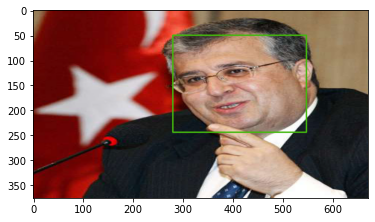

Done predictions with time 0.497 s
[[ 91.29375672  44.3232224  130.73284864 152.31571293]
 [239.44656765 104.52813339  72.7643373   93.38953733]
 [451.94564939  69.52171671 125.19642019 162.15468621]]
(3,)


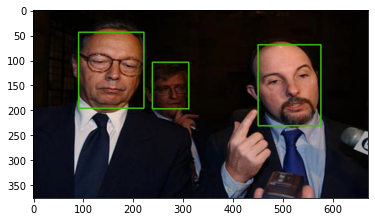

Done predictions with time 0.446 s
[[318.27131653  47.87022138 134.52171707 131.12448502]
 [  7.29973984  46.26297486  92.26142406 126.50495744]]
(2,)


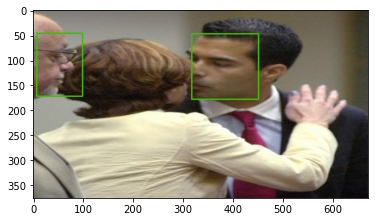

Done predictions with time 0.484 s
[[200.1269052   32.84859061 110.89123964  90.23486018]]
(1,)


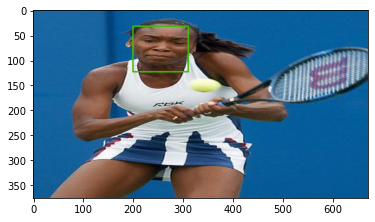

Done predictions with time 0.476 s
[[124.66990614  40.2954272  165.57717419 104.31477737]
 [  6.29018068   9.95293218  91.87747335  78.54089415]
 [378.1788801   -6.33354735  72.98586774  42.60219067]
 [124.66990614  40.2954272  165.57717419 104.31477737]]
(4,)


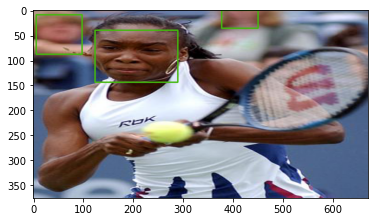

Done predictions with time 0.457 s
[[115.64007998  50.28272158 108.42390347  84.98571384]
 [421.77465677  14.96350694 129.38577175 102.14735365]]
(2,)


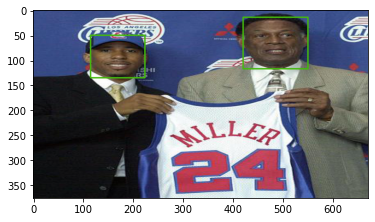

In [17]:
i=0


for valid_images, target_bbox, target_class, filename in dataset:
    
    start = time.time()
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")
    now=(time.time()-start)
    print("Done predictions with time %.3f s"%now)

    boxes = boxes_output(valid_images[0], predicted_bbox, scores=predicted_scores)
        
    bboxes = xy_min_xy_max_to_xywh(boxes)#x_min, y_min, w, h
    print(bboxes)
    
    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=['background', 'heads'], 
        config=config
    )
    plt.imshow(result)
    #plt.savefig("ex_%d.png"%i)
    plt.show()
    i+=1
    if i>5:
        break

## Speed measurement

In [19]:
times = []
for _ in range(110):
    start = time.perf_counter()
    m_outputs = detr(valid_images, training=False)
    #predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")
    times.append(time.perf_counter() - start)
    
times = np.array(times)
times = times[10:]
print(times.mean(), times.std())

0.2663512479999997 0.0061743348498521635
